# xDB Training

A notebook exploring the xDB dataset tier3 part for Building Segmentation Model and Damaged Classification Model

In [1]:
# In a Jupyter notebook or IPython environment, run this in the first cell
%load_ext autoreload
%autoreload 2

In [63]:
%reload_ext autoreload

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Define the transformation pipeline
def get_train_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        # Random horizontal flip
        A.HorizontalFlip(p=0.8),
        # Random vertical flip
        A.VerticalFlip(p=0.8),
        # Random rotation
        A.RandomRotate90(p=0.05),
        # Random brightness and contrast adjustments
        A.RandomBrightnessContrast(p=0.2),
        # Random contrast adjustment
        A.RandomGamma(p=0.2),
        # Random scale and aspect ratio change
        A.RandomSizedCrop(min_max_height=(image_size[0], image_size[1]), size=(image_size[0], image_size[1]), p=0.8, w2h_ratio=0.5),
        # Random blur
        A.GaussianBlur(p=0.2),
        # Convert to tensor (works for both image and mask)
        ToTensorV2()
    ])
    return transform

def get_val_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        ToTensorV2()
    ])
    return transform

In [11]:
from datasets import xDB_Damaged_Building

origin_dir = "../data/xDB/tier3"

data_train  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_train_augmentation_pipeline(image_size=(512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_val  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="val",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_test  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="test",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 5097 train labels.
Loaded 636 val labels.
Loaded 636 test labels.


In [6]:
from models import ResNet_UNET 

model = ResNet_UNET(
        in_channels=3,
        out_channels=2,
        backbone_name="resnet34",
        pretrained=True,
        freeze_backbone=False,
    )

In [7]:
import torch
from torchsummary import summary 
# Before training, wrap the model for Data Parallelism
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

model.to("cuda")

summary(model, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=6, pin_memory=True,drop_last=True)
val_dl = DataLoader(data_val, batch_size=8, shuffle=False, num_workers=6, pin_memory=True)

In [9]:
from torch.nn.modules.loss import _Loss
from typing import List

class Ensemble(_Loss):
    def __init__(
        self,
        list_losses: List[_Loss] = [],
        weights: List[float] = []
    ):
        super().__init__()
        self.list_losses = list_losses
        self.weights = weights

        assert len(list_losses) > 0, "List of losses cannot be empty."
        assert len(weights) == len(list_losses), "Weights must match the number of losses."

        # Normalize weights to sum to 1
        total_weight = sum(self.weights)
        assert total_weight > 0, "Weights must sum to a positive value."
        self.weights = [w / total_weight for w in self.weights]

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the weighted ensemble loss.
        
        :param inputs: Predictions from the model.
        :param targets: Ground truth labels.
        :return: Weighted ensemble loss.
        """
        total_loss = 0.0
        for weight, loss_fn in zip(self.weights, self.list_losses):
            loss = loss_fn(inputs, targets)
            total_loss += weight * loss
        
        return total_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from training import train 
from losses import SoftCrossEntropyLoss
from losses import DiceLoss, FocalLoss
from metrics import accuracy, f1_score, iou_score

mode = "multiclass"
optimizer = optim.AdamW(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.00015, weight_decay=1e-6)
params_opt = {}
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 11, 17, 25, 33, 47, 50, 60, 70, 90, 110, 130, 150, 170, 180, 190], gamma=0.5)

params_sc = {}
criterion = Ensemble(list_losses=[DiceLoss(mode=mode), FocalLoss(mode=mode)], weights= [1.0,10.0]).cuda() #nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.6]).to("cuda"))
# Define Metrics 
metrics = [accuracy, f1_score, iou_score]

# Early Stopping 
early_stopping_params = {"patience":5, "trigger_times": 0}

torch.cuda.empty_cache()
train(
    model,
    train_dl=train_dl,
    valid_dl=val_dl,
    optimizer=optimizer,
    scheduler=scheduler,
    params_opt=params_opt,
    params_sc=params_sc,
    metrics=metrics,
    nb_epochs=55,
    loss_fn=criterion,
    experiment_name="xDB_UNet_test",
    log_dir="../runs",
    model_dir="../models",
    early_stopping_params = early_stopping_params,
    image_key="image",
    training_log_interval=1,
    verbose=False,
    is_mixed_precision=True
)


In [68]:
test_dl = DataLoader(data_test, batch_size=5, shuffle=True)

In [69]:
input_test = next(iter(test_dl))
outputs = model.predict(input_test["image"].to("cuda"))

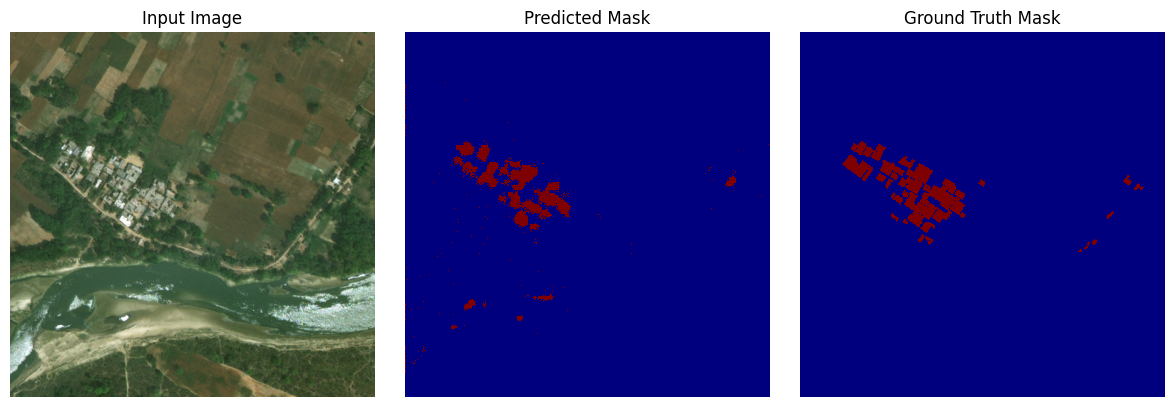

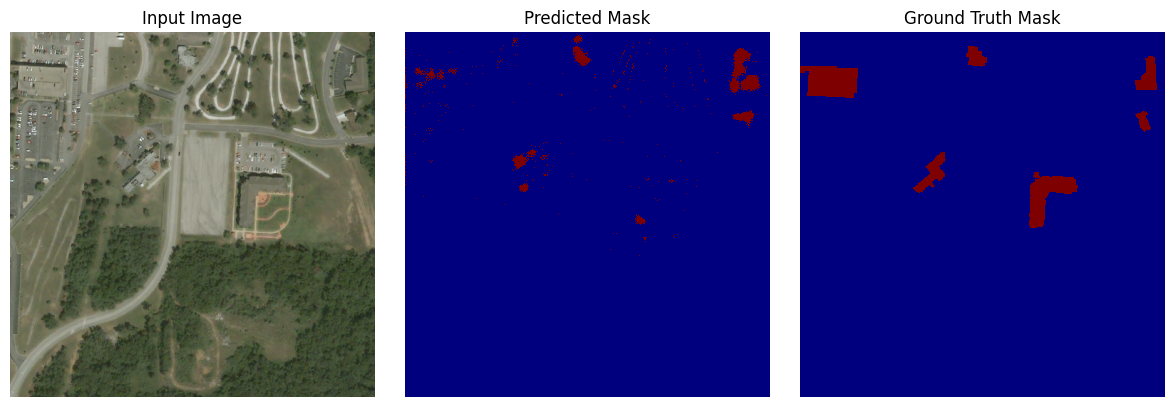

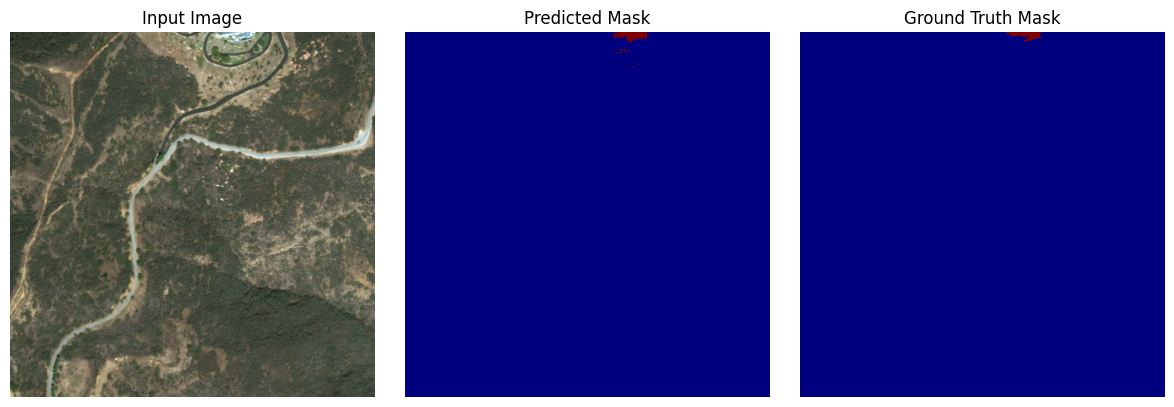

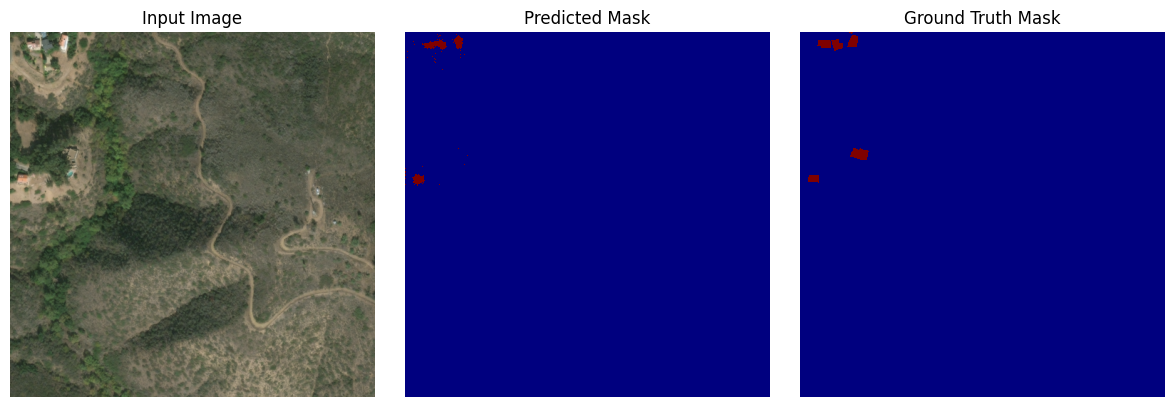

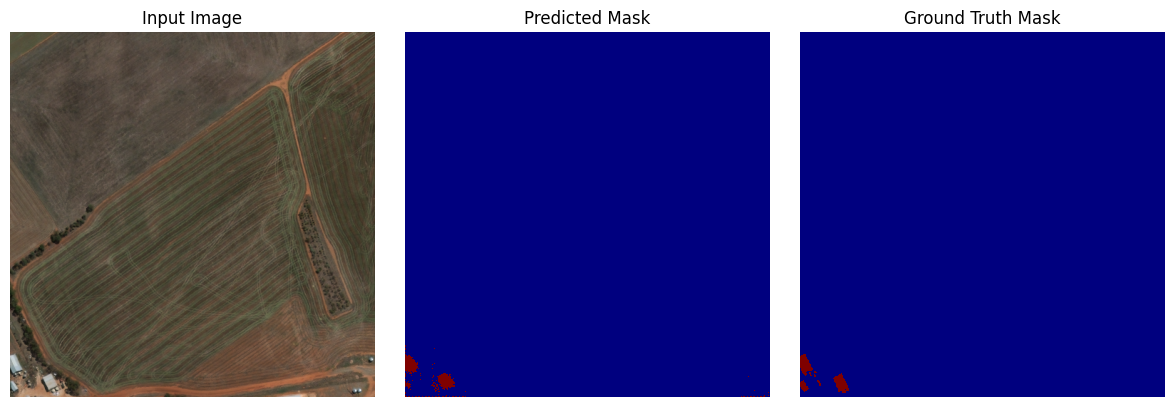

In [70]:
from utils import display_predictions_batch

display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs,
    mask_labels=input_test["mask"]
    )

In [ ]:
from training import augmentation_test_time
import numpy as np
# Define Albumentations augmentations
augmentations = [
    A.HorizontalFlip(p=1.0),  # Horizontal flip
    A.VerticalFlip(p=1.0)    # Vertical flip
]
outputs_tta = augmentation_test_time(model, input_test, list_augmentations=augmentations, aggregation="mean", image_tag="image", device="cuda" )
outputs_tta = np.argmax(outputs_tta, axis=1) 

In [ ]:
display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs_tta,
    mask_labels=input_test["mask"]
    )

In [67]:
from training import testing 
from metrics import (f1_score,
    iou_score,
    balanced_accuracy
    )

weights = [[0, 1],[0.1, 0.9],[0.2, 0.8],[0.3, 0.7],[0.4, 0.6],[0.5, 0.5]]  # Different class weight combinations

for class_weights in weights:  # Iterate over different class weight combinations
    print(f"\nTesting with class weights: {class_weights}")
    
    avg_loss, averaged_metrics = testing(
        model=model,
        test_dataloader=test_dl,  # Assuming `test_dl` is your DataLoader for test data
        loss_fn=criterion,
        metrics=[
            f1_score, 
            iou_score, 
            balanced_accuracy
        ], 
        image_key="image",  # Assuming test_dl provides image tensors under this key
        num_classes=2,  # Assuming binary segmentation
        is_mixed_precision=True,  # Use mixed precision for testing if applicable
        verbose=True,
        reduction="weighted",  # Using weighted reduction
        class_weights=class_weights
    )
    
    print("Testing Loss:", avg_loss)
    print("Model Metrics on the Test Set:")
    for name, value in averaged_metrics.items():
        print(f"{name} = {value}")


Testing with class weights: [0, 1]


Testing:   0%|          | 0/64 [00:00<?, ?batch/s]

Testing: 100%|██████████| 64/64 [00:34<00:00,  1.84batch/s, Loss=0.24] 


Testing Loss: 0.2555227214060489
Model Metrics on the Test Set:
f1_score = 0.6316221356391907
iou_score = 0.470750629901886
balanced_accuracy = 0.7895861268043518

Testing with class weights: [0.1, 0.9]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.85batch/s, Loss=0.282]


Testing Loss: 0.25550047945488924
Model Metrics on the Test Set:
f1_score = 0.6862667202949524
iou_score = 0.5372713804244995
balanced_accuracy = 0.8018075823783875

Testing with class weights: [0.2, 0.8]


Testing: 100%|██████████| 64/64 [00:35<00:00,  1.83batch/s, Loss=0.247]


Testing Loss: 0.2555269870274472
Model Metrics on the Test Set:
f1_score = 0.7129417061805725
iou_score = 0.5797074437141418
balanced_accuracy = 0.7981458306312561

Testing with class weights: [0.3, 0.7]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.85batch/s, Loss=0.287]


Testing Loss: 0.2555014713661476
Model Metrics on the Test Set:
f1_score = 0.7519799470901489
iou_score = 0.6347607970237732
balanced_accuracy = 0.7985049486160278

Testing with class weights: [0.4, 0.6]


Testing: 100%|██████████| 64/64 [00:35<00:00,  1.83batch/s, Loss=0.288]


Testing Loss: 0.2555084834871052
Model Metrics on the Test Set:
f1_score = 0.7860669493675232
iou_score = 0.6848582625389099
balanced_accuracy = 0.8001018166542053

Testing with class weights: [0.5, 0.5]


Testing: 100%|██████████| 64/64 [00:34<00:00,  1.84batch/s, Loss=0.241]

Testing Loss: 0.25546974688768387
Model Metrics on the Test Set:
f1_score = 0.8208732604980469
iou_score = 0.7372741103172302
balanced_accuracy = 0.8001319766044617


### Test Post Processing operation 

In [6]:
from datasets import xDB_Damaged_Building
origin_dir = "../data/data_samples/xDB/tier3"

data_train  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_train_augmentation_pipeline(image_size=(512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 3 train labels.


In [70]:
inputs = data_train[0]

In [73]:
import numpy as np
from PIL import Image
import cv2

# Assume inputs contain "image" and "mask" as keys
image, mask = inputs["image"], inputs["mask"]

# Ensure the mask is a NumPy array
mask = np.array(mask)

# Convert the binary mask values (1 -> 255, others -> 0) for visualization or further processing
binary_mask = np.where(mask == 1, 255, 0).astype(np.uint8)

"""before_cleaning_mask = Image.fromarray(binary_mask)

# Apply morphological closing to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Define a kernel size
cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Convert the cleaned mask back to an image
after_cleaning_mask = Image.fromarray(cleaned_mask)"""


'before_cleaning_mask = Image.fromarray(binary_mask)\n\n# Apply morphological closing to remove noise\nkernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Define a kernel size\ncleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)\n\n# Convert the cleaned mask back to an image\nafter_cleaning_mask = Image.fromarray(cleaned_mask)'

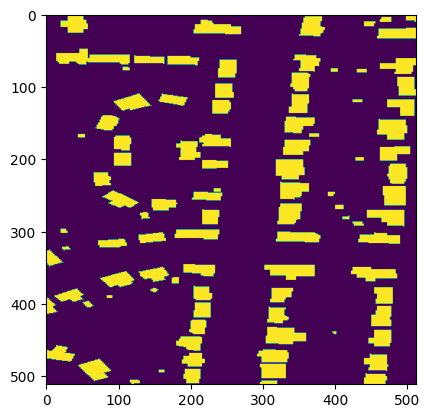

In [81]:
plt.imshow(mask)

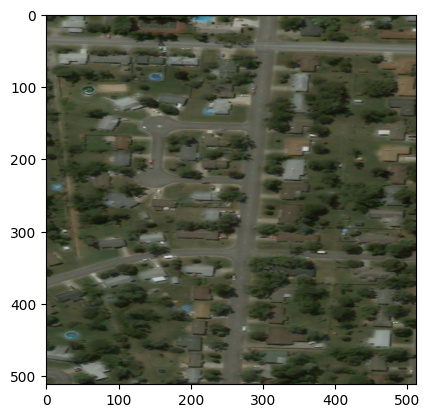

In [86]:
plt.imshow(np.array(image).transpose(1,2,0))

### Transform Semantic Segmentation Mask into Object Instance Segmentation Mask

In [74]:
import numpy as np
import cv2
# Semantic segmentation mask (e.g., 1 for buildings, 0 for background)
semantic_mask = np.array(mask)  # Binary mask, shape: (H, W)

# Ensure binary mask format
binary_mask = (semantic_mask == 1).astype(np.uint8)

# Connected component labeling
num_labels, instance_mask = cv2.connectedComponents(binary_mask)

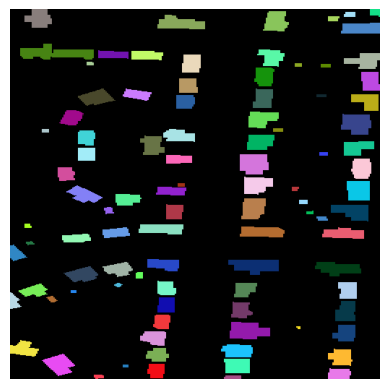

In [76]:
# Visualize the Instance Mask
# import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Random color mapping
def random_color_map(instance_mask):
    unique_ids = np.unique(instance_mask)
    color_map = {uid: np.random.randint(0, 255, 3) for uid in unique_ids if uid != 0}
    color_mask = np.zeros((*instance_mask.shape, 3), dtype=np.uint8)
    for uid, color in color_map.items():
        color_mask[instance_mask == uid] = color
    return color_mask

# Visualize
colored_instance_mask = random_color_map(instance_mask)
plt.imshow(colored_instance_mask)
plt.axis('off')
plt.show() 

In [77]:
### Compute the bounding boxes from the binary mask
def compute_bounding_boxes_from_instance_mask(instance_mask):
    """
    Compute bounding boxes from an instance segmentation mask.
    
    Args:
        instance_mask (numpy.ndarray): Instance mask of shape (H, W) where each instance has a unique ID.
    
    Returns:
        Dict of bounding boxes {instance_id: (x_min, y_min, x_max, y_max)}.
    """
    bounding_boxes = {}
    unique_ids = np.unique(instance_mask)
    
    for instance_id in unique_ids:
        if instance_id == 0:  # Skip background
            continue
        
        # Create binary mask for the current instance
        binary_mask = (instance_mask == instance_id).astype(np.uint8)
        
        # Find contours and compute bounding box
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes[instance_id] = (x, y, x + w, y + h)
    
    return bounding_boxes

In [78]:
bounding_boxes = compute_bounding_boxes_from_instance_mask(instance_mask=instance_mask)

In [88]:
def draw_bounding_boxes(image, bounding_boxes):
    """
    Draw bounding boxes on an image.
    
    Args:
        image (numpy.ndarray): Original image (H, W, C).
        bounding_boxes (List[Tuple[int, int, int, int]]): List of bounding boxes [(x_min, y_min, x_max, y_max)].
    
    Returns:
        numpy.ndarray: Image with bounding boxes drawn.
    """
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)  # Green box
    
    return image

In [89]:
from torchvision.transforms import ToPILImage

image_np = np.array(image).transpose(1,2,0)
bounding_boxes = [v for k, v in bounding_boxes.items()]
image_with_bbx = draw_bounding_boxes(image_np, bounding_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


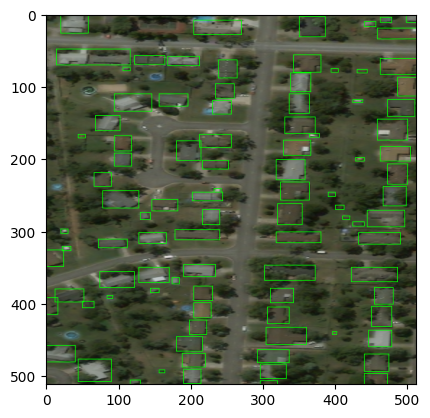

In [90]:
plt.imshow(image_with_bbx)
plt.show() 

To fine tune Mask R CNN an Instance Segmentation Model we need the images and the mask 
The masks will be splitted in different colors 

In [ ]:
def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [ ]:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html